# The Solow Model with Alternative Specifications for Human Capital

This project explores the Solow Model with alternative specifications for Human Capital. First, I present the Solow Model with Human Capital, then I derive analytical and numerical steady-state solutions, visualize the outcomes, and analyze parameter dependence. Lastly, I investigate an alternative human capital specification involving two distinct worker groups: highly educated and unskilled.

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# my modules
import random
import matplotlib.pyplot as plt

# local modules
from modelproject import n_ss_solow, multi_start, null_clines, find_intersection

# Predefined options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 12})

## The Solow Model with Human Capital

The Solow Model with Human Capital is given by:
\begin{aligned}
    Y_{t} &= K^{\alpha}_{t}H^{\varphi}_{t}(A_{t}L_{t})^{1-\alpha-\varphi}, \quad 0<\alpha,\varphi<1 \hspace{4em} &(1)\\
    L_{t+1} &= (1+n)L_{t}, \quad L_{0} \text{ given} \hspace{4em} &(2)\\
    A_{t+1} &= (1+g)A_{t}, \quad A_{0}  \text{ given} \hspace{4em} &(3)\\
    K_{t+1} &= s_{K}Y_{t} + (1-\delta)K_{t}, \quad K_{0} \text{ given} \hspace{4em} &(4)\\
    H_{t+1} &= s_{H}Y_{t} + (1-\delta)H_{t}, \quad H_{0} \text{ given} \hspace{4em} &(5)
\end{aligned}

1. The Cobb-Douglas production function represents output, $Y_{t}$, as a function of physical capital, $K_{t}$, human capital, $H_{t}$, technology, $A_{t}$, and labor $L_{t}$. <br>
2. The labor force, $L_{t+1}$, accumulates over time according to population growth, $1+n$. <br>
3. Total factor productivity (TFP, represented as $A_{t}$), accumulates over time according to TFP growth, $1+g$. <br>
4. Physical capital, $K_{t+1}$, accumulates over time through investment in physical capital, $s_{K}Y_{t}$, and depreciation of physical capital, $(1-\delta)K_{t}$. <br>
5. Human capital, $H_{t+1}$, accumulates over time through investment in human capital, $s_{H}Y_{t}$, and depreciation of human capital, $(1-\delta)H_{t}$.

### Steady State Solutions

#### Analytical Solution

The Solow Model with Human Capital has two Solow equations, (6) and (7). The model is analyzed in tilde-variables, $\tilde{x_{t}} = \frac{X_{t}}{A_t{t}L_{t}}$, which are constant in steady state. The non-tilde per capita variables, $x_{t}$, change in steady state. 

\begin{aligned}
    \tilde{k}_{t+1}-\tilde{k}_{t} &= \frac{1}{(1+n)(1+g)}(s_{K}\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}-(n+g+\delta+ng)\tilde{k}_{t}) \hspace{4em} &(6)\\
    \tilde{h}_{t+1}-\tilde{h}_{t} &= \frac{1}{(1+n)(1+g)}(s_{H}\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}-(n+g+\delta+ng)\tilde{h}_{t}) \hspace{4em} &(7)
\end{aligned}

In steady state $\tilde{k}_{t+1}=\tilde{k}_{t}=\tilde{k}^{\star}$ and $\tilde{h}_{t+1}=\tilde{h}_{t}=\tilde{h}^{\star}$. 

To solve for steady state, I define variables and parameters as `SymPy.symbols` , formulate steady-state Solow equations, set the left hand side of the  equations to zero, and use `SymPy.solve`.

In [2]:
# Create a SymPy symbol for each variable and parameter
k, h, s_K, s_H, n, g, delta, alpha, varphi = sm.symbols('k, h, s_K, s_H, n, g, delta, alpha, varphi')

# Set the Solow equations in steady state as SumPy equations
ss_solow_k = sm.Eq(0, (1 / ((1 + n) * (1 + g))) * (s_K * k**alpha * h**varphi - (n + g + delta + n * g) * k))
ss_solow_h = sm.Eq(0, (1 / ((1 + n) * (1 + g))) * (s_H * k**alpha * h**varphi - (n + g + delta + n * g) * h))

# Try to solve the systems of equations algebraically for k and h using SumPy
try:
    ss_k_h = sm.solve([ss_solow_k, ss_solow_h], (k, h))
except (NotImplementedError):
    print('Unable to solve the system of equations algebraically.')

Unable to solve the system of equations algebraically.


Using 'SymPy' for non-linear equations proves limited, so I adopt an alternative. I use Sørensen and Whitta-Jacobsen's steady-state equations for capital and human capital, (8) and (9). I construct lambdified expressions and calculate steady-state capital and human capital values.

\begin{aligned}
    \tilde{k}_{t}^{\star} = \left(\frac{s_K^{1-\varphi}s_H^{\varphi}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}} \hspace{4em} (8) \\
    \tilde{h}_{t}^{\star} = \left(\frac{s_K^{\alpha}s_H^{1-\alpha}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}} \hspace{4em} (9)
\end{aligned}

In [3]:
# Set the steady state equations
ss_k = ((s_K**(1-varphi) * s_H**varphi) / (n + g + delta + n * g))**(1 / (1 - alpha - varphi))
ss_h = ((s_K**(alpha) * s_H**(1-alpha)) / (n + g + delta + n * g))**(1 / (1 - alpha - varphi))

# Create a function for the steady state of k and h using SymPy lambdify
ss_func = sm.lambdify(args = (s_K, s_H, n, g, delta, alpha, varphi), expr = (ss_k, ss_h))

I set the name of the parameter values to the name of each parameter plus `_val` to not overwrite the original values.

In [4]:
# Set parameter values
s_K_val = 0.3
s_H_val = 0.2
n_val = 0.02
g_val = 0.02
delta_val = 0.1
alpha_val = 1/3
varphi_val = 1/3

Given the parameter values, I find the steady state values of capital and human capital.

In [5]:
# Call each steady state function for the parameter values
ss_k_func, ss_h_func = ss_func(s_K_val, s_H_val, n_val, g_val, delta_val, alpha_val, varphi_val)

# Prints the steady state value for capital and human capital
print(f'Analytical solution:\n\
There are {ss_k_func:.3f} units of capital, and {ss_h_func:.3f} units of human capital in steady state.')

Analytical solution:
There are 6.504 units of capital, and 4.336 units of human capital in steady state.


#### Numerical Solution

Now, that I have an analytical solution independent of any algorithm's initial values or tolerance, I can employ an optimizer to determine the steady state values for capital and human capital and compare the results to the analytical solution. 

In [6]:
# Guess on values
initial_guess = [2, 2]

# Solve the function for steady state using the n_ss_solow function 
sol = optimize.root(fun = n_ss_solow,
                    x0 = initial_guess, 
                    args = (s_K_val, s_H_val, n_val, g_val, delta_val, alpha_val, varphi_val), 
                    method = 'hybr', 
                    tol = 1e-5)

# Save the steady state values
num_ss_k, num_ss_h = sol.x

# Print the steady-state values of capital and human capital
print(f'Numerical Solution:\n\
There are {num_ss_k:.3f} units of capital, and {num_ss_h:.3f} units of human capital in steady state')

Numerical Solution:
There are 6.504 units of capital, and 4.336 units of human capital in steady state


Given a "good" initial guess, the numerical solution is the same as the analytical. The downside to the simple optimizer is that it is highly sensitive to the initial guess, i.e., `initial_guess = [1, 1]` does not converge given the parameter values. To address this issue, I employ a multi-start optimization technique.
The multi-start optimization takes a specified number of random initial guesses within a bounded range for the variables. For each guess, it solves for the steady-state variables, calculates the residual of the function, and stores both the solution and the residual. Finally, it returns the solution with the smallest residual, corresponding to the best convergence or minimum error among all the initial guesses.
This approach improves the reliability of the optimization results by exploring multiple starting points and selecting the solution that provides the best convergence.

In [7]:
# Call the Multi-Start function to find the steady state values of capital and human capital
ms_ss_k, ms_ss_h, smallest_residual = multi_start(num_guesses=100,
            bounds = [1e-5, 10],
            fun = n_ss_solow, 
            args = (s_K_val, s_H_val, n_val, g_val, delta_val, alpha_val, varphi_val), 
            method = 'hybr')

# Print the steady-state values for capital and human capital
print(f'Muti-Start Solution:\n\
There are {ms_ss_k:.3f} units of capital, and {ms_ss_h:.3f} units of human capital in steady state\n\
The functions residual is {smallest_residual:.0e}')

Muti-Start Solution:
There are 6.504 units of capital, and 4.336 units of human capital in steady state
The functions residual is 1e-16


The solution shows that the Multi-Start optimizer is a highly stable method, consistently finding the correct answer. One may increase the number of guesses within the given bounds to increase precision. However, it is important to note that increasing the number of guesses can be time-consuming.

#### Graphical Solution

##### Phase Diagram

To find the steady state graphically, I set  $\Delta\tilde{k_t} = \tilde{k}_{t+1}-\tilde{k}_{t} = 0$ and $\Delta\tilde{h_t} = \tilde{h}_{t+1}-\tilde{h}_{t} = 0$ in the Solow equations, (6) and (7). Next, I solve each equation for $\tilde{h}_{t}$.


\begin{aligned}
    \tilde{h}_{t} &= \left(\frac{n+g+\delta+ng}{s_K}\right)^{\frac{1}{\varphi}}\tilde{k}_{t}^{\frac{1-\alpha}{\varphi}}   \hspace{4em} (10) \\
    \tilde{h}_{t} &= \left(\frac{s_H}{n+g+\delta+ng}\right)^{\frac{1}{\varphi}}\tilde{k}_{t}^{\frac{\varphi}{1-\alpha}}   \hspace{4em} (11)
\end{aligned}


These new equations, (10) and (11), called null clines, show the equilibrium for capital and human capital. 


To solve for the null clines, I call the function `null_clines` with the specified parameters. 

In [8]:
# Call the function null_clines with the parameter values
k_vec, h_vec_k, h_vec_h = null_clines(s_K_val, s_H_val, g_val, n_val, alpha_val, varphi_val, delta_val)

Next, I plot the null clines.

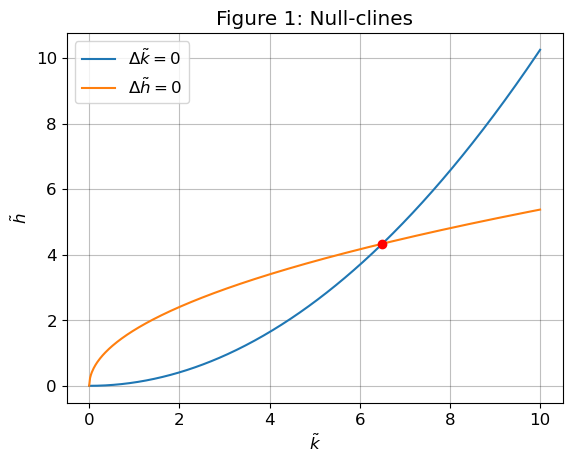

In [12]:
# Create the figure
fig = plt.figure()

# Create the plot 
ax = fig.add_subplot(1,1,1)

# Set null-clines
ax.plot(k_vec, h_vec_k, label= r'$\Delta \tilde{k}=0$')
ax.plot(k_vec, h_vec_h, label= r'$\Delta \tilde{h}=0$')

# Find index of intersection
k_vec_inter, h_vec_k_inter, h_vec_h_inter = find_intersection(k_vec, h_vec_k, h_vec_h)

# Mark the intersection on the plot
ax.plot(k_vec_inter, h_vec_k_inter, 'ro')

# Set title, labels and legend
ax.set_title('Figure 1: Null-clines')
ax.set_xlabel(r'$\tilde{k}$')
ax.set_ylabel(r'$\tilde{h}$')
ax.legend(loc='upper left');

I am sorry, but this is as far as I have gotten with the model project. 
I will finalize the project before the exam.